In [1]:
#Section 1: Setup and Imports
#Import necessary libraries
import numpy as np  #Fundamental package for scientific computing, handles n-dimensional arrays.
import pandas as pd #Data manipulation and analysis library, used for DataFrames.
import matplotlib.pyplot as plt #Primary plotting library for creating static, interactive visualizations.
from mpl_toolkits.mplot3d import Axes3D #For 3D plotting capabilities.
import seaborn as sns #Statistical data visualization built on matplotlib, provides prettier plots.

#Scikit-learn modules for clustering and preprocessing
from sklearn.cluster import KMeans, DBSCAN #Our chosen clustering algorithms.
from sklearn.preprocessing import StandardScaler #To standardize features to have mean=0 and variance=1.
from sklearn import metrics #For evaluating clustering performance (optional advanced use).

#For displaying plots directly in the Jupyter notebook
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #Clean up the notebook by ignoring common warning messages.

In [2]:
#Section 2: Data Loding
#!!! CRITICAL: Set this path to match YOUR local folder structure !!!
#This points to the directory that contains your CSV files.
#For example, if your files are in "C:\MyProject\data\", set data_dir to that.
data_dir = "../data/train_1/"  #This is the most common structure if your notebook is in a 'notebooks' folder.

#Load the three main files for a single event.
#We'll use event000001000 for this example.
event_prefix = "event000001000-"

hits = pd.read_csv(data_dir + event_prefix + 'hits.csv')
particles = pd.read_csv(data_dir + event_prefix + 'particles.csv')
truth = pd.read_csv(data_dir + event_prefix + 'truth.csv')

#Let's examine what we've loaded
print("Hits DataFrame Shape:", hits.shape)
print(hits.head(), '\n')

print("Particles DataFrame Shape:", particles.shape)
print(particles.head(), '\n')

print("Truth DataFrame Shape:", truth.shape)
print(truth.head())

Hits DataFrame Shape: (120939, 7)
   hit_id        x         y       z  volume_id  layer_id  module_id
0       1 -64.4099 -7.163700 -1502.5          7         2          1
1       2 -55.3361  0.635342 -1502.5          7         2          1
2       3 -83.8305 -1.143010 -1502.5          7         2          1
3       4 -96.1091 -8.241030 -1502.5          7         2          1
4       5 -62.6736 -9.371200 -1502.5          7         2          1 

Particles DataFrame Shape: (12263, 9)
        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.01006

In [3]:
#EDA (exploratory data analysis)
#Basic statistics of the hit coordinates
print(hits[['x', 'y', 'z']].describe())

                   x              y              z
count  120939.000000  120939.000000  120939.000000
mean       -1.769455       4.751040      -2.315079
std       305.715117     305.173087    1061.912453
min     -1024.840000   -1025.110000   -2955.500000
25%      -100.146000     -95.896500    -655.800000
50%        -1.651340       1.005920      -1.800000
75%        97.267650     103.224000     655.800000
max      1025.330000    1024.850000    2955.500000


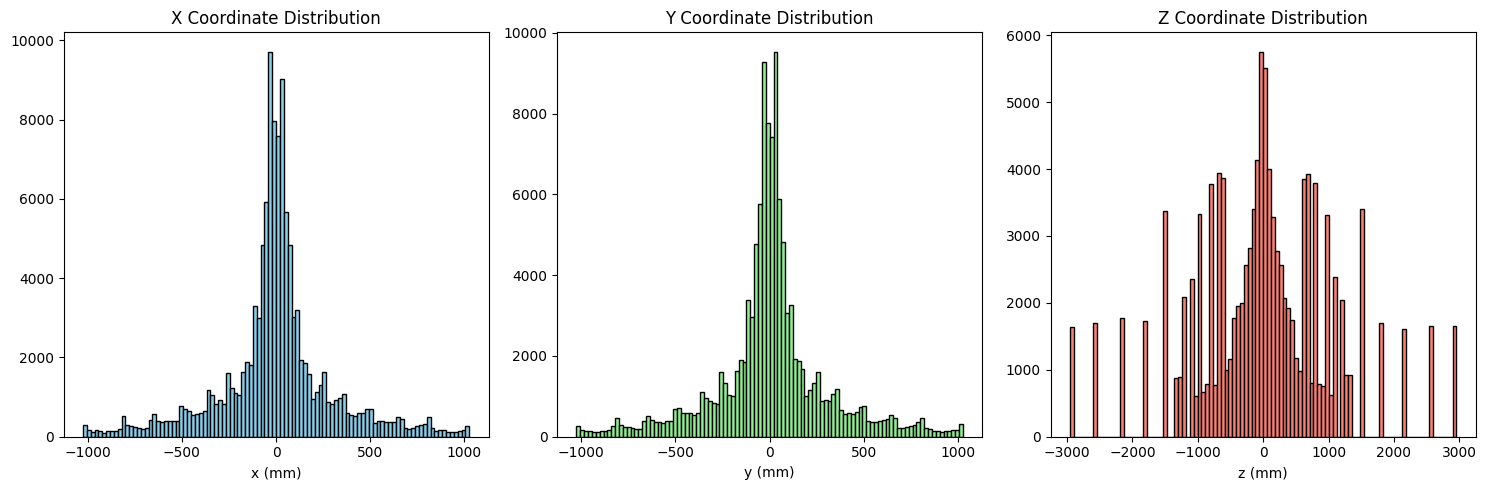

In [4]:
#Create histograms for the x, y, and z coordinates
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(hits['x'], bins=100, color='skyblue', edgecolor='black')
axs[0].set_title('X Coordinate Distribution')
axs[0].set_xlabel('x (mm)')

axs[1].hist(hits['y'], bins=100, color='lightgreen', edgecolor='black')
axs[1].set_title('Y Coordinate Distribution')
axs[1].set_xlabel('y (mm)')

axs[2].hist(hits['z'], bins=100, color='salmon', edgecolor='black')
axs[2].set_title('Z Coordinate Distribution')
axs[2].set_xlabel('z (mm)')

plt.tight_layout()
plt.show()

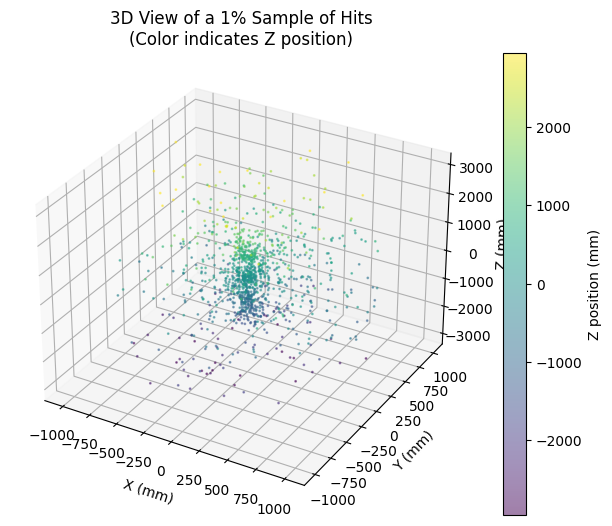

In [5]:
#Plot a 1% random sample of hits in 3D to see the detector structure
sample_hits = hits.sample(frac=0.01, random_state=42) #Take a 1% sample for clarity

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#Scatter plot
sc = ax.scatter(sample_hits['x'], sample_hits['y'], sample_hits['z'],
                c=sample_hits['z'], cmap='viridis', alpha=0.5, s=1) #Color by z-value
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('3D View of a 1% Sample of Hits\n(Color indicates Z position)')
plt.colorbar(sc, label='Z position (mm)')
plt.show()

In [6]:
#Section 4: Data Preprocessing
#Extract the 3D coordinates into a feature matrix X
X = hits[['x', 'y', 'z']].values
print("Shape of feature matrix X:", X.shape)

#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("First 5 rows of X_scaled:\n", X_scaled[:5])

Shape of feature matrix X: (120939, 3)
First 5 rows of X_scaled:
 [[-0.20489894 -0.03904272 -1.4127258 ]
 [-0.17521825 -0.01348649 -1.4127258 ]
 [-0.26842436 -0.01931387 -1.4127258 ]
 [-0.30858806 -0.04257297 -1.4127258 ]
 [-0.19921945 -0.04627635 -1.4127258 ]]


True number of unique particles in this event: 10566


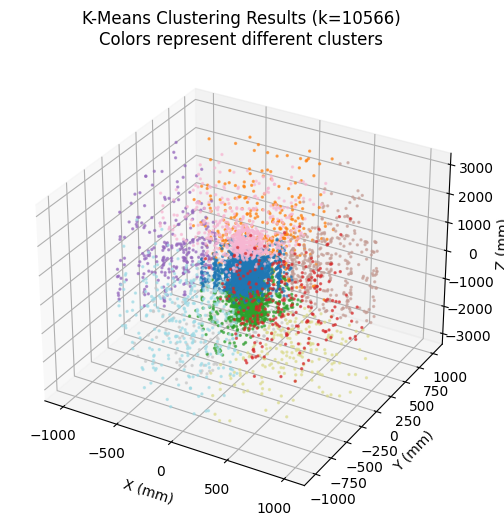

In [10]:
#Section 5: Clustering with K-Means (Baseline)
#Find the true number of particles (k) for this event from the truth table
#We merge the truth and hits table on 'hit_id' to get the particle_id for each hit.
merged = pd.merge(hits, truth, on='hit_id')
n_particles = merged['particle_id'].nunique()
print(f"True number of unique particles in this event: {n_particles}")

#Run K-Means with the true k
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto') #n_init silences a future warning
#changing n_clusters to 10 instead of n_particles so that k-means algorithm works 
cluster_labels_kmeans = kmeans.fit_predict(X_scaled)

#Plot the K-Means results (plot another sample for speed)
sample_for_plot = hits.sample(frac=0.05, random_state=42) #5% sample
sample_labels = cluster_labels_kmeans[sample_for_plot.index] #Get the labels for the sample points

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(sample_for_plot['x'], sample_for_plot['y'], sample_for_plot['z'],
                c=sample_labels, cmap='tab20', alpha=0.6, s=2) #Color by cluster label
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title(f'K-Means Clustering Results (k={n_particles})\nColors represent different clusters')
plt.show()

#It won't run because  K-Means algorithm has a time complexity that is roughly proportional to- O(n * k * I * d)
#Trying to find 10,000+ clusters in a million-point dataset is not feasible with standard K-Means on a personal computer. 
#It will take an extremely long time or run out of memory.

DBSCAN found 12 clusters.
Number of points classified as noise: 83 (0.07%)


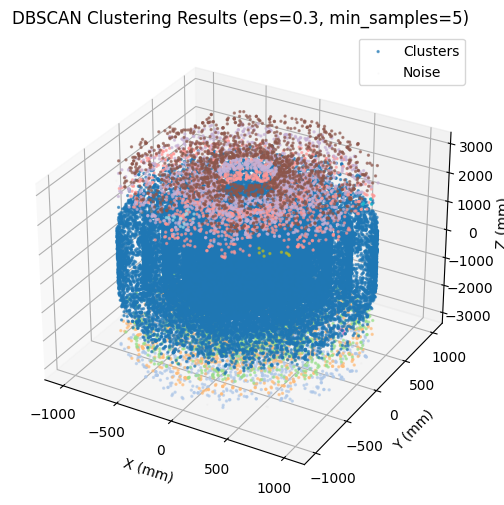

In [12]:
#Section 6: Clustering with DBSCAN
#Run DBSCAN. We need to guess parameters. Let's start with eps=0.3 and min_samples=5.
dbscan = DBSCAN(eps=0.3, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(X_scaled)

#Analyze the results
n_clusters = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise = list(cluster_labels_dbscan).count(-1)

print(f"DBSCAN found {n_clusters} clusters.")
print(f"Number of points classified as noise: {n_noise} ({n_noise/len(cluster_labels_dbscan)*100:.2f}%)")

#Plot the DBSCAN results, filtering out noise points for clarity
is_noise = cluster_labels_dbscan == -1
hits_noise = hits[is_noise]
hits_clustered = hits[~is_noise]
labels_clustered = cluster_labels_dbscan[~is_noise]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#Plot clustered points
sc_cluster = ax.scatter(hits_clustered['x'], hits_clustered['y'], hits_clustered['z'],
                        c=labels_clustered, cmap='tab20', alpha=0.6, s=2, label='Clusters')

#Plot noise points in grey
sc_noise = ax.scatter(hits_noise['x'], hits_noise['y'], hits_noise['z'],
                      c='grey', alpha=0.02, s=1, label='Noise')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('DBSCAN Clustering Results (eps=0.3, min_samples=5)')
plt.legend()
plt.show()


Cluster ID vs. Number of Points in Cluster:
Cluster -1: 83 points
Cluster 0: 110907 points
Cluster 1: 1631 points
Cluster 2: 1686 points
Cluster 3: 1754 points
Cluster 4: 1576 points
Cluster 5: 1637 points
Cluster 6: 1627 points
Cluster 7: 6 points
Cluster 8: 4 points
Cluster 9: 9 points
Cluster 10: 5 points
Cluster 11: 14 points

Stats of the SCALED data (X_scaled):
                  0             1             2
count  1.209390e+05  1.209390e+05  1.209390e+05
mean  -1.034038e-17  1.504055e-17 -3.760138e-17
std    1.000004e+00  1.000004e+00  1.000004e+00
min   -3.346497e+00 -3.374692e+00 -2.781018e+00
25%   -3.217929e-01 -3.298061e-01 -6.153875e-01
50%    3.863574e-04 -1.227217e-02  4.850503e-04
75%    3.239536e-01  3.226804e-01  6.197477e-01
max    3.359676e+00  3.342704e+00  2.785378e+00

Trying a smaller eps value (e.g., 0.1):
DBSCAN(eps=0.1) found 1248 clusters.
Number of points classified as noise: 12619 (10.43%)


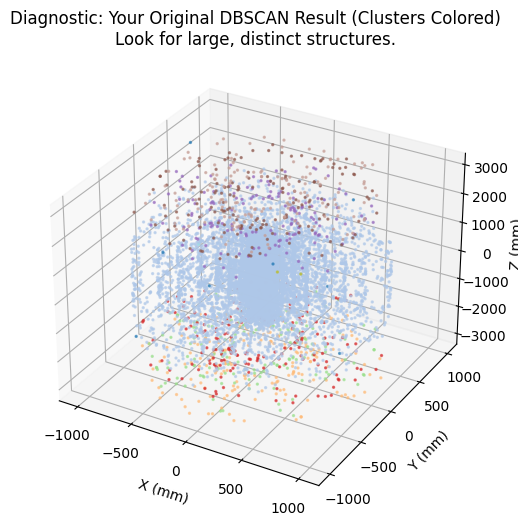

In [14]:
#DIAGNOSTICS: Let's investigate the clusters DBSCAN found.

#1. Check the size of the clusters it found
unique_labels, counts = np.unique(cluster_labels_dbscan, return_counts=True)
print("\nCluster ID vs. Number of Points in Cluster:")
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")

#2. Check the scale of our data (this is critical)
print(f"\nStats of the SCALED data (X_scaled):")
print(pd.DataFrame(X_scaled).describe())
#The EPS parameter (0.3) is applied to this scaled data

#3. Let's try a much smaller EPS value to see if we can resolve more tracks
print("\nTrying a smaller eps value (e.g., 0.1):")
dbscan_tight = DBSCAN(eps=0.1, min_samples=5)
labels_tight = dbscan_tight.fit_predict(X_scaled)

n_clusters_tight = len(set(labels_tight)) - (1 if -1 in labels_tight else 0)
n_noise_tight = list(labels_tight).count(-1)
print(f"DBSCAN(eps=0.1) found {n_clusters_tight} clusters.")
print(f"Number of points classified as noise: {n_noise_tight} ({n_noise_tight/len(labels_tight)*100:.2f}%)")

#4. (Most Important) Let's plot the results from the original DBSCAN again, but color by cluster and look at the structure.

#Get a sample for plotting (e.g., 10%)
plot_sample = hits.sample(frac=0.1, random_state=42)
sample_labels = cluster_labels_dbscan[plot_sample.index]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#Plot each cluster from your original result
sc = ax.scatter(plot_sample['x'], plot_sample['y'], plot_sample['z'],
                c=sample_labels, cmap='tab20', alpha=0.6, s=2) 

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('Diagnostic: Your Original DBSCAN Result (Clusters Colored)\nLook for large, distinct structures.')
plt.show()